##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Proximities and Prototypes with Random Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/proximities_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/proximities_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/proximities_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/proximities_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

[Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman), the author of the [random forest](https://developers.google.com/machine-learning/glossary#random-forest) learning algorithm, [proposed](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#scaling) a method to
measure the *proximity* (also known as *similarity)* between two examples using a pre-trained Random Forest (RF) model. He qualifies this method as <i>"[...] one of the most useful tools in random forests."</i>. In this Notebook, we implement this method and show how to use it to interpret models.

This notebook is implemented using the [TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests) library. This document is easier to understand if you are familiar with the content of the [Beginner colab](beginner_colab.ipynb).

## Proximities

A **proximity** (or a **similarity**) between two examples is a number
indicating how "close" those two examples are. Following is an example of similarity in between the 3 examples $\{e_1, e_2, e_3\}$:

$$
\mathrm{proxy}(e_1, e_2) = 0.1 \\
\mathrm{proxy}(e_2, e_3) = 9.6 \\
\mathrm{proxy}(e_3, e_1) = 4.1 \\
$$

For convenience, the proximity between examples is represented in matrix form:

|    	| $e_1$ 	| $e_2$ 	| $e_3$ 	|
|----	|----	|----	|----	|
| $e_1$ 	|  $\mathrm{proxy}(e_1, e_1)$  	|  $\mathrm{proxy}(e_1, e_2)$  	| $\mathrm{proxy}(e_1, e_3)$   	|
| $e_2$ 	|  $\mathrm{proxy}(e_2, e_1)$  	|  $\mathrm{proxy}(e_2, e_2)$  	| $\mathrm{proxy}(e_2, e_3)$   	|
| $e_3$ 	|  $\mathrm{proxy}(e_3, e_1)$  	|  $\mathrm{proxy}(e_3, e_2)$  	| $\mathrm{proxy}(e_3, e_3)$   	|

Proximities are used in multiple data analysis techniques, including clustering, dimensionality reductions or nearest neighbor analysis. For this reason, it is a great tool for **models** and **predictions interpretation**.

Unfortunately, measuring the proximity between two tabular examples is not straightforward as different columns might describe different quantities. For example, try to define the proximity in between the following examples.

species | weight | num_legs | age     | sex
------- | ------ | -------- | ------- | ------
cat     | 2 kg   | 4        | 2 y     | male
dog     | 6 kg   | 4        | 12 y    | female
spider  | 5 g    | 8        | 3 weeks | female

To define the similarity between two rows in the table above, you need to specify how much a *difference in weight* compares to a *difference in the number of legs*, or in ages. In addition, relations might be non-linear or be conditional on other columns. For example, dogs live longer than spiders, so maybe, a one year difference for a spider should not count the same one year of age for a dog.

Instead of manually defining those relations, Breiman's proximity turns a random forest model (which we know how to train on a tabular dataset), into a proximity metric.

## Proximities with random forests

A random forest is a collection of decision trees. The prediction of the random the aggregation of the predictions of the individual trees. The prediction of a decision tree is computed by routing an example from the root to forest is one of the leaves according to node conditions. The leaf reached
by the example $i$ in the tree $t$ is called its *active* leaf and noted $\mathrm{leaf}(i,t)$

Breiman defines the proximity between two examples as the ratio of shared active leafs between those two examples. Formally, the proximity between example $i$ and example $j$ is:

$$
\mathrm{prox}(i,j) = \mathrm{prox}(j,i) = \frac{1}{|\mathrm{Trees}|} \sum_{t \in \mathrm{Trees}} \left[ \mathrm{leaf}(i,t) = \mathrm{leaf}(j,t) \right]
$$

with $\mathrm{leaf}(j,t)$ the index of the active leaf for the example $j$ in
the tree $t$.

Informally, if two examples are often routed to the same leaves (i.e. the two examples have the same active leaves), those examples are similar.

Let's implement this proximity function and use it in some examples.

## Setup

In [2]:
# Install TensorFlow Dececision Forests and the dependencies used in this colab.
!pip install tensorflow_decision_forests plotly scikit-learn wurlitzer -U -qq

In [3]:
import tensorflow_decision_forests as tfdf

import matplotlib.colors as mcolors
import math
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go

2022-11-23 12:09:15.027555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-23 12:09:15.027652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-23 12:09:15.027662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Train a Random Forest model

The method relies on a pre-trained random forest model. First, we train a random forest model with [TensorFlow Decision Forests library](https://www.tensorflow.org/decision_forests) on the [Adult](https://archive.ics.uci.edu/ml/datasets/adult) binary classification dataset. The Adult dataset is well suited for this example as it contains columns that don't have a natural way to be compared.

In [4]:
# Download a copy of the adult dataset.
!wget -q https://raw.githubusercontent.com/google/yggdrasil-decision-forests/main/yggdrasil_decision_forests/test_data/dataset/adult_train.csv -O /tmp/adult_train.csv
!wget -q https://raw.githubusercontent.com/google/yggdrasil-decision-forests/main/yggdrasil_decision_forests/test_data/dataset/adult_test.csv -O /tmp/adult_test.csv

In [5]:
# Load the dataset in memory
train_df = pd.read_csv("/tmp/adult_train.csv")
test_df = pd.read_csv("/tmp/adult_test.csv")

# , and convert it into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="income")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="income")

Following are the first five examples of the training dataset. Notice that
different columns represent different quantities. For example, how would you compare
the distance between *relationship* and *age*?

In [6]:
# Print the first 5 examples.
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,44,Private,228057,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,Dominican-Republic,<=50K
1,20,Private,299047,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,20,United-States,<=50K
2,40,Private,342164,HS-grad,9,Separated,Adm-clerical,Unmarried,White,Female,0,0,37,United-States,<=50K
3,30,Private,361742,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<=50K
4,67,Self-emp-inc,171564,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,20051,0,30,England,>50K


A Random Forest is trained as follows:

In [7]:
# Train a Random Forest
model = tfdf.keras.RandomForestModel(num_trees=1000)
model.fit(train_ds)

Use /tmpfs/tmp/tmpxpsa62ou as temporary training directory


Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:03.666538. Found 22792 examples.


Training model...


[INFO 2022-11-23T12:09:31.144007853+00:00 kernel.cc:1175] Loading model from path /tmpfs/tmp/tmpxpsa62ou/model/ with prefix 4d8ebcbe59a2451c


[INFO 2022-11-23T12:09:35.665899507+00:00 abstract_model.cc:1306] Engine "RandomForestGeneric" built
[INFO 2022-11-23T12:09:35.665947684+00:00 kernel.cc:1021] Use fast generic engine


Model trained in 0:00:10.480653


Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.


The performance of the Random Forest model is:

In [8]:
model_inspector = model.make_inspector()
out_of_bag_accuracy = model_inspector.evaluation().accuracy
print(f"Out-of-bag accuracy: {out_of_bag_accuracy:.4f}")

Out-of-bag accuracy: 0.8653


This is an expected accuracy value for Random Forest models on this dataset. It indicates that the model is correctly trained.

We can also measure the accuracy of the model on the test datasets:

In [9]:
# The test accuracy is measured on the test datasets.
model.compile(["accuracy"])
test_accuracy = model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8663


## Proximities

First, we inspect the number of trees in the model and the number of examples in the test datasets.

In [10]:
print("The model contains", model_inspector.num_trees(), "trees.")
print("The test dataset contains", test_df.shape[0], "examples.")

The model contains 1000 trees.
The test dataset contains 9769 examples.


The method [predict_get_leaves()](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel) returns the index of the active leaf for each example and each tree.

In [11]:
leaves = model.predict_get_leaves(test_ds)
print("The leaf indices:\n", leaves)

[INFO 2022-11-23T12:09:41.06379579+00:00 kernel.cc:1175] Loading model from path /tmpfs/tmp/tmpxpsa62ou/model/ with prefix 4d8ebcbe59a2451c


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[INFO 2022-11-23T12:09:44.649709738+00:00 kernel.cc:1027] Use slow generic engine
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The leaf indices:
 [[498 193 142 ... 457 221 198]
 [399 466 423 ... 288 420 444]
 [639 651 562 ... 608 636 625]
 ...
 [149 296 258 ... 153 310 316]
 [481 186 131 ... 432 192 153]
 [  9   0  28 ...   4   1  42]]


In [12]:
print("The predicted leaves have shape", leaves.shape,
      "(we expect [num_examples, num_trees]")

The predicted leaves have shape (9769, 1000) (we expect [num_examples, num_trees]


Here, `leaves[i,j]` is the index of the active leaf of the i-th
example in the j-th tree.

**Note:** In this notebook, we won't need the actual leaf prediction values. However, they are available through the `model_inspector`.

Next, we implement the $\mathrm{prox}$ equation define earlier.

**Note:** This step is slow.

In [13]:
def compute_proximity(leaves, step_size=100):
  """Computes the proximity between each pair of examples.

  Args:
    leaves: A matrix of shape [num_example, num_tree] where the value [i,j] is
      the index of the leaf reached by example "i" in the tree "j".
    step_size: Size of the block of examples for the computation of the
      proximity. Does not impact the results.

  Returns:
    The example pair-wise proximity matrix of shape [n,n] with "n" the number of
    examples.
  """

  example_idx = 0
  num_examples = leaves.shape[0]
  t_leaves = np.transpose(leaves)
  proximities = []

  # Instead of computing the proximity in between all the examples at the same
  # time, we compute the similarity in blocks of "step_size" examples. This
  # makes the code more efficient with the the numpy broadcast.
  while example_idx < num_examples:
    end_idx = min(example_idx + step_size, num_examples)
    proximities.append(
        np.mean(
            leaves[..., np.newaxis] == t_leaves[:,
                                                example_idx:end_idx][np.newaxis,
                                                                     ...],
            axis=1))
    example_idx = end_idx
  return np.concatenate(proximities, axis=1)


proximity = compute_proximity(leaves)
print("The shape of proximity is", proximity.shape)

The shape of proximity is (9769, 9769)


Here, `proximity[i,j]` is the proximity in between the example `i` and `j`.

The proximity matrix:

In [14]:
proximity

array([[1.   , 0.   , 0.   , ..., 0.   , 0.053, 0.   ],
       [0.   , 1.   , 0.   , ..., 0.002, 0.   , 0.   ],
       [0.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.002, 0.   , ..., 1.   , 0.   , 0.   ],
       [0.053, 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 1.   ]])

The proximity matrix has several interesting properties, notably, it is symmetrical, positive, and the diagonal elements are all 1.

## Projection

Our first use of the proximity is to project the examples on the two dimensional plane.

If $\mathrm{prox} \in [0,1]$ is a proximity, $1 - \mathrm{prox}$ is a distance
between examples. Breiman proposes to compute the inner products of those distances, and to plot
the [eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors). See details
[here](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#scaling).

Instead, we will use the
[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)
which is a more modern way to visualize high-dimensional data.

**Note:** We use the [t-SNE's Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [15]:
distance = 1 - proximity

t_sne = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=2,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    square_distances=True,
    learning_rate="auto").fit_transform(distance)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:830: FutureWarning:

The parameter `square_distances` has not effect and will be removed in version 1.3.



[t-SNE] Computing 61 nearest neighbors...


[t-SNE] Indexed 9769 samples in 0.206s...


[t-SNE] Computed neighbors for 9769 samples in 1.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9769
[t-SNE] Computed conditional probabilities for sample 2000 / 9769
[t-SNE] Computed conditional probabilities for sample 3000 / 9769
[t-SNE] Computed conditional probabilities for sample 4000 / 9769
[t-SNE] Computed conditional probabilities for sample 5000 / 9769
[t-SNE] Computed conditional probabilities for sample 6000 / 9769
[t-SNE] Computed conditional probabilities for sample 7000 / 9769
[t-SNE] Computed conditional probabilities for sample 8000 / 9769
[t-SNE] Computed conditional probabilities for sample 9000 / 9769
[t-SNE] Computed conditional probabilities for sample 9769 / 9769
[t-SNE] Mean sigma: 0.188051


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.190346


[t-SNE] KL divergence after 1000 iterations: 1.117140


The next plot shows a two-dimensional projection of the test example features. The color of the points
represent the label values. Note that the label values were not available to the model.

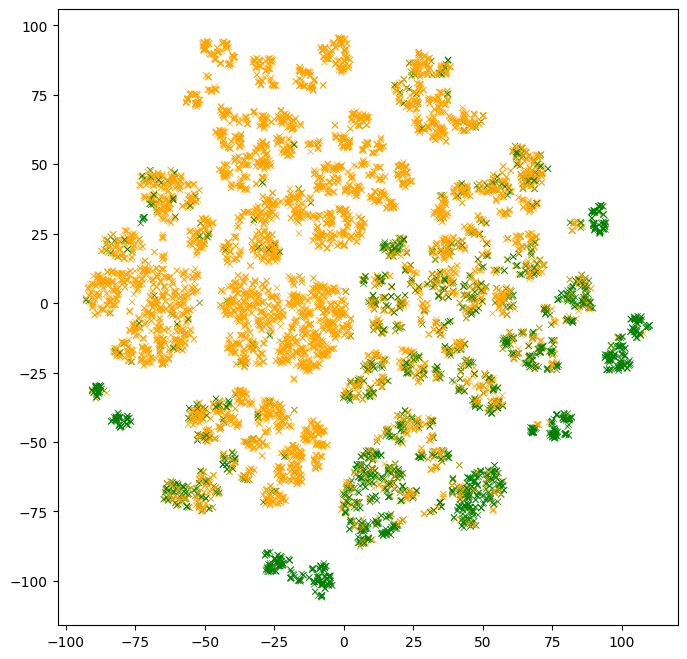

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid(False)

# Color the points according to the label value.
colors = (test_df["income"] == ">50K").map(lambda x: ["orange", "green"][x])
ax.scatter(
    t_sne[:, 0], t_sne[:, 1], c=colors, linewidths=0.5, marker="x", s=20)

**Observations:**

- There are clusters of points with similar colors. Those are examples that are easy for the model to classify.
- There are multiple clusters with the same color. Those multiple clusters show examples with the same label, but for "different reasons" according to the model.
- Clusters with mixed colors contain examples where the model performs poorly. In the part above, we evaluated the model test accuracy to ~86%. Those are likely those examples.

The previous plot is a static image. Let's turn it into an interactive plot and inspect the individual examples.

In [ ]:
# docs_infra: no_execute

# Note: Run the colab (click the "Run in Google Colab" link at the top) to see
# the interactive plot.

def interactive_plot(dataset, projections):

  def label_fn(row):
    """HTML printer over each example."""
    return "<br>".join([f"<b>{k}:</b> {v}" for k, v in row.items()])

  labels = list(dataset.apply(label_fn, axis=1).values)
  iplot({
      "data": [
          go.Scatter(
              x=projections[:, 0],
              y=projections[:, 1],
              text=labels,
              mode="markers",
              marker={
                  "color": colors,
                  "size": 3,
              })
      ],
      "layout": go.Layout(width=600, height=600, template="simple_white")
  })


interactive_plot(test_df, t_sne)

**Instructions:** Put the mouse pointer over some examples, and try to make sense of them. Compare them to their neighbors.

**Not seeing the interactive plot?:** Run the colab with [this link](https://colab.sandbox.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/proximities_colab.ipynb) to see the interactive plot.

Instead of coloring the examples according to the label values, we can color the examples according to each feature values:

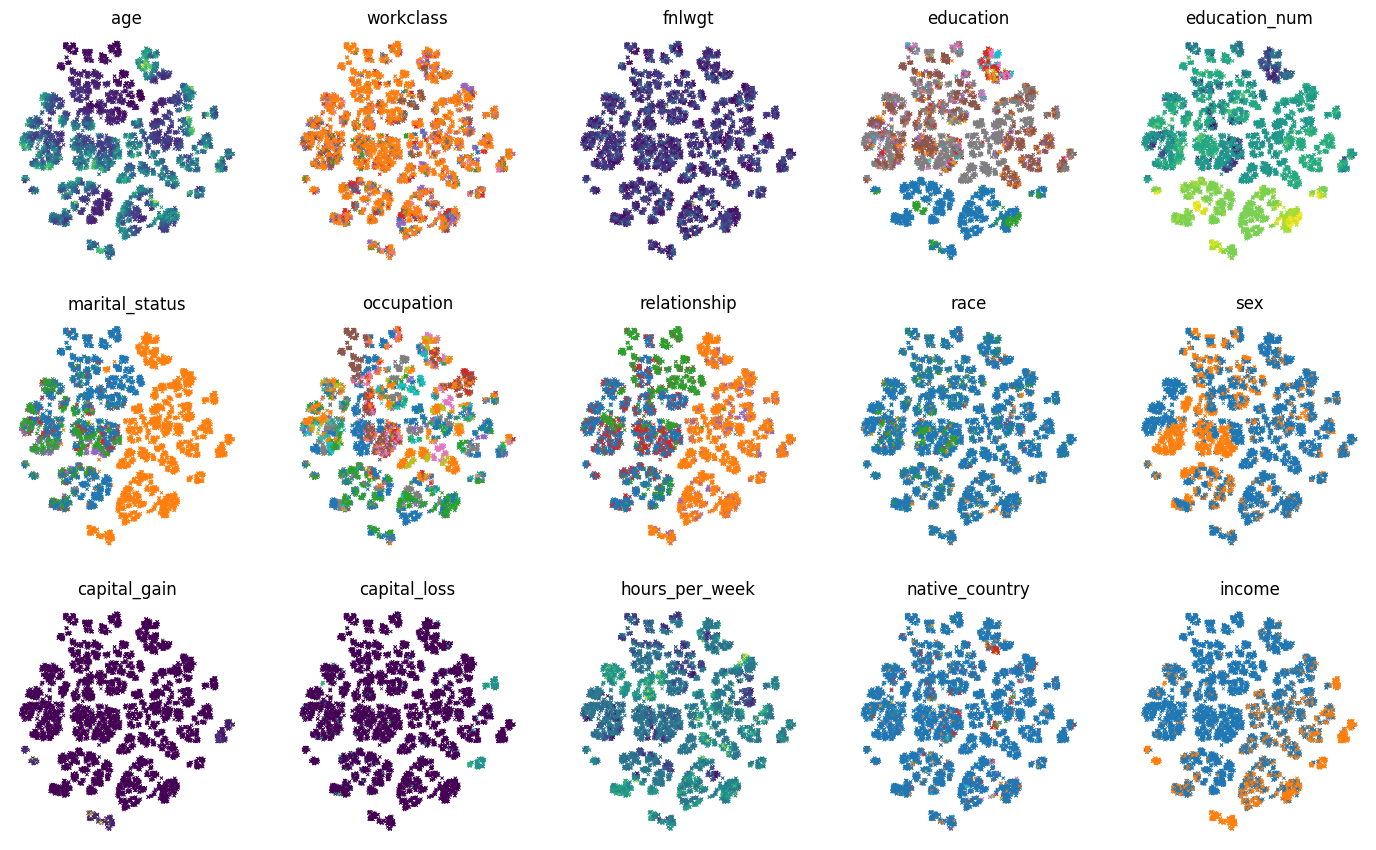

In [17]:
# Number of columns and rows in the multi-plot.
num_plot_cols = 5
num_plot_rows = math.ceil(test_df.shape[1] / num_plot_cols)

# Color palette for the categorical features.
palette = list(mcolors.TABLEAU_COLORS.values())

# Create the plot
plot_size_in = 3.5
fig, axs = plt.subplots(
    num_plot_rows,
    num_plot_cols,
    figsize=(num_plot_cols * plot_size_in, num_plot_rows * plot_size_in))

# Hide the borders.
for row in axs:
  for ax in row:
    ax.set_axis_off()

for col_idx, col_name in enumerate(test_df):
  ax = axs[col_idx // num_plot_cols, col_idx % num_plot_cols]

  colors = test_df[col_name]
  if colors.dtypes in [str, object]:
    # Use the color palette on categorical features.
    unique_values = list(colors.unique())
    colors = colors.map(
        lambda x: palette[unique_values.index(x) % len(palette)])

  ax.set_title(col_name)
  ax.scatter(t_sne[:, 0], t_sne[:, 1], c=colors.values, linewidths=0.5,
      marker="x", s=5)

## Prototypes

Trying to make sense of an example by looking at all its neighbors is not always efficient. Instead, we could "group" similar examples to make this task easier. This is the underlying idea behind *prototypes*.

**Prototypes** are examples, not necessarily in the original dataset, that are representative of large trends in the dataset. Looking at prototypes is a solution to understand a dataset. For more details, see the [chapter 8.7](https://christophm.github.io/interpretable-ml-book/proto.html) of [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) by Molnar.

Prototypes can be computed in different ways, for example using a clustering algorithm. Instead, Breiman proposed a specific solution based on a simple iterative algorithm. The algorithm is as follow:

1.  Select the example surrounded with the highest number of neighbors with the same class among its k nearest neighbors.
2. Create a prototype example using the median feature values of the selected example and its k neighbors.
3. Remove those k+1 examples
4. Repeat

Informally, prototypes are centers of clusters in the plots we created above.

Let's implement this algorithm and look at some prototypes.

First the method that selects the example in step 1.

In [18]:
def select_example(labels, distance_matrix, k):
  """Selects the example with the highest number of neighbors with the same class.

  Usage example:
    n = 5
    select_example(
        np.random.randint(0,2, size=n),
        np.random.uniform(size=(n,n)),
        2)

  Returns:
    The list of neighbors for the selected example. Includes the selected
    example.
  """

  partition = np.argpartition(distance_matrix, k)[:,:k]
  same_label = np.mean(np.equal(labels[partition], np.expand_dims(labels, axis=1)), axis=1)
  selected_example = np.argmax(same_label)
  return partition[selected_example, :]

In [19]:
def extract_prototype_examples(labels, distance_matrix, k, num_prototypes):
  """Extracts a list of examples in each prototype.

  Usage example:
    n = 50
    print(extract_prototype_examples(
        labels=np.random.randint(0, 2, size=n),
        distance_matrix=np.random.uniform(size=(n, n)),
        k=2,
        num_prototypes=3))

  Returns:
    An array where E[i][j] is the index of the j-th examples of the i-th
    prototype. 
  """

  example_idxs = np.arange(len(labels))
  prototypes = []
  examples_per_prototype = []

  for iter in range(num_prototypes):
    print(f"Iter #{iter}")
    # Select the example
    neighbors = select_example(labels, distance_matrix, k)

    # Index of the examples in the prototype
    examples_per_prototype.append(list(example_idxs[neighbors]))

    # Remove the selected examples
    example_idxs = np.delete(example_idxs, neighbors)
    labels = np.delete(labels, neighbors)
    distance_matrix = np.delete(distance_matrix, neighbors, axis=0)
    distance_matrix = np.delete(distance_matrix, neighbors, axis=1)

  return examples_per_prototype

Using the methods above, let's extract the examples for 10 prototypes.

**Note:** The parameter `k` controls the number of elements in a cluster. Changing its value will impact the prototypes.

In [20]:
examples_per_prototype = extract_prototype_examples(test_df["income"].values, distance, k=20, num_prototypes=10)
print(f"Found examples for {len(examples_per_prototype)} prototypes.")

Iter #0


Iter #1


Iter #2


Iter #3


Iter #4


Iter #5


Iter #6


Iter #7


Iter #8


Iter #9


Found examples for 10 prototypes.


For each of those prototypes, we want to display the statistics of the feature values. In this example, we will look at the quartiles of the numerical features, and the most frequent values for the categorical features.

In [21]:
def build_prototype(dataset):
  """Exacts the feature statistics of a prototype.
  
  For numerical features, returns the quantiles.
  For categorical features, returns the most frequent value.

  Usage example:
    n = 50
    print(build_prototype(
        pd.DataFrame({
            "f1": np.random.uniform(size=n),
            "f2": np.random.uniform(size=n),
            "f3": [f"v_{x}" for x in np.random.randint(0, 2, size=n)],
            "label": np.random.randint(0, 2, size=n)
        })))
        
  Return:
    A prototype as a dictionary of strings.
  """

  prototype = {}
  for col in dataset.columns:
    col_values = dataset[col]
    if col_values.dtypes in [str, object]:
      # A categorical feature.

      # Remove the missing values
      col_values = [x for x in col_values if isinstance(x,str) or not math.isnan(x)]

      # Frequency of each possible value.
      frequency_item, frequency_count = np.unique(col_values, return_counts=True)
      top_item_idx = np.argmax(frequency_count)
      top_item_probability = frequency_count[top_item_idx] / np.sum(frequency_count)

      # Print the most common item.
      prototype[col] = f"{frequency_item[top_item_idx]} ({100*top_item_probability:.0f}%)"

    else:
      # A numerical feature.
      quartiles = np.nanquantile(col_values.values, [0.25, 0.5, 0.75])
      # Print the 3 quantiles.
      prototype[col] = f"{quartiles[0]} {quartiles[1]} {quartiles[2]}"
  return prototype

Now, let's look at our prototypes.

**Note:** The table shows the "25%-quantile median 75%-quantile" for each numerical feature.

In [22]:
# Extract the statistics of each prototype.
prototypes = []
for examples in examples_per_prototype:
  # Prorotype statistics.
  prototypes.append(build_prototype(test_df.iloc[examples, :]))
prototypes = pd.DataFrame(prototypes)

prototypes

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,36.0 39.0 41.0,Private (50%),72314.0 115188.5 138797.0,Bachelors (95%),13.0 13.0 13.0,Never-married (65%),Adm-clerical (70%),Not-in-family (75%),White (95%),Male (65%),0.0 0.0 0.0,0.0 0.0 0.0,38.75 40.0 40.0,United-States (100%),<=50K (100%)
1,29.0 32.5 35.0,Private (70%),78407.25 107019.0 173157.75,7th-8th (30%),4.0 5.0 6.0,Married-civ-spouse (100%),Other-service (55%),Husband (70%),White (70%),Male (70%),0.0 0.0 0.0,0.0 0.0 0.0,40.0 40.0 40.0,United-States (83%),<=50K (100%)
2,21.0 22.5 23.0,Private (80%),180021.75 205655.0 247491.0,HS-grad (30%),9.0 10.0 11.25,Never-married (95%),Craft-repair (30%),Not-in-family (80%),White (100%),Male (95%),0.0 0.0 0.0,0.0 0.0 0.0,50.0 55.0 60.0,United-States (100%),<=50K (100%)
3,38.5 47.0 51.25,Private (95%),169612.75 232097.5 293209.25,11th (50%),4.5 7.0 7.0,Never-married (65%),Machine-op-inspct (70%),Not-in-family (50%),White (90%),Male (80%),0.0 0.0 0.0,0.0 0.0 0.0,40.0 40.0 40.0,United-States (50%),<=50K (100%)
4,20.0 20.5 21.0,Private (95%),163459.5 194955.5 232958.25,Some-college (100%),10.0 10.0 10.0,Never-married (100%),Handlers-cleaners (45%),Own-child (100%),White (95%),Male (90%),0.0 0.0 0.0,0.0 0.0 0.0,38.75 40.0 40.0,United-States (95%),<=50K (100%)
5,67.75 69.5 73.25,Private (67%),137598.0 197241.5 250026.75,10th (30%),3.75 5.0 6.0,Married-civ-spouse (100%),Prof-specialty (44%),Husband (100%),White (80%),Male (100%),0.0 0.0 0.0,0.0 0.0 0.0,7.5 15.5 20.0,United-States (95%),<=50K (100%)
6,38.5 45.0 52.75,Private (74%),113752.5 167555.5 212834.75,HS-grad (65%),9.0 9.0 10.0,Divorced (55%),Craft-repair (26%),Not-in-family (90%),White (75%),Male (60%),10520.0 14084.0 14149.0,0.0 0.0 0.0,40.0 40.0 40.0,United-States (95%),>50K (100%)
7,27.0 28.0 28.0,Private (90%),159338.25 205247.5 249295.75,Some-college (75%),9.75 10.0 10.0,Never-married (60%),Adm-clerical (45%),Unmarried (55%),White (55%),Female (95%),0.0 0.0 0.0,0.0 0.0 0.0,24.75 38.0 40.0,United-States (100%),<=50K (100%)
8,39.75 42.5 48.0,Private (45%),165462.25 203200.5 235193.0,Prof-school (50%),15.0 15.0 16.0,Married-civ-spouse (100%),Prof-specialty (80%),Husband (100%),White (90%),Male (100%),0.0 0.0 0.0,1902.0 1977.0 1977.0,45.0 50.0 60.0,United-States (95%),>50K (100%)
9,29.0 29.5 31.25,Private (95%),105338.5 136133.5 192047.25,HS-grad (95%),9.0 9.0 9.0,Never-married (90%),Craft-repair (95%),Not-in-family (80%),White (95%),Male (100%),0.0 0.0 0.0,0.0 0.0 0.0,40.0 40.0 40.0,United-States (95%),<=50K (100%)


Try to make sense of the prototypes.

Let's extract and plot the mean 2d t-SNE projection of the elements in those prototypes.

In [23]:
# Extract the projection of each prototype.
prototypes_projection = []
for examples in examples_per_prototype:
  # t-SNE for each prototype.
  prototypes_projection.append(np.mean(t_sne[examples,:],axis=0))
prototypes_projection = np.stack(prototypes_projection)

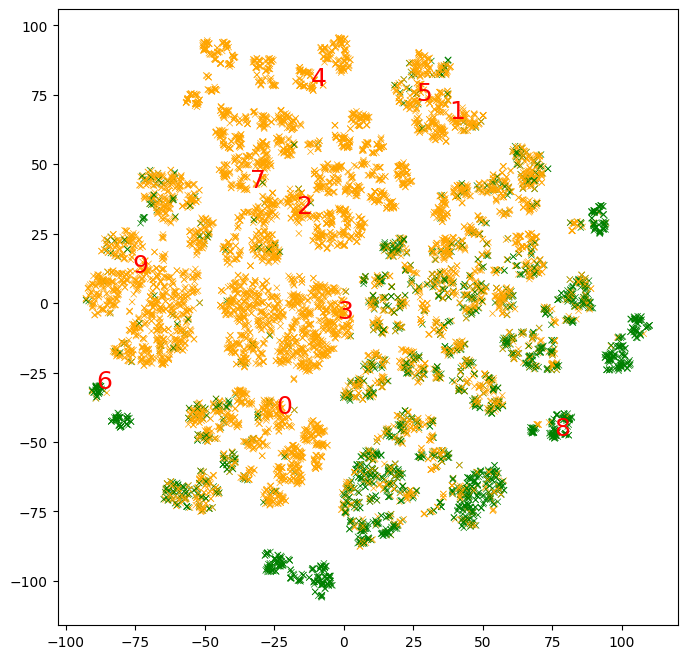

In [24]:
# Plot the mean 2d t-SNE projection of the elements in the prototypes.

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid(False)

# Color the points according to the label value.
colors = (test_df["income"] == ">50K").map(lambda x: ["orange", "green"][x])
ax.scatter(
    t_sne[:, 0], t_sne[:, 1], c=colors, linewidths=0.5, marker="x", s=20)

# Add the prototype indices.
for i in range(prototypes_projection.shape[0]):
  ax.text(prototypes_projection[i, 0],
          prototypes_projection[i, 1],
          f"{i}",
          fontdict={"size":18},
          c="red")

We see that the 10 prototypes cover around half of the domain. Clusters of examples without a prototype would be best explained with more prototypes.

In the example above, we extracted the prototypes automatically. However, we can also build prototypes around specific examples.

Let's create the prototype around the example #0.


In [25]:
example_idx = 0
k = 20
neighbors = np.argpartition(distance[example_idx, :], k)[:k]

print(f"The example #{example_idx} is:")
print("===============================")
print(test_df.iloc[example_idx, :])
print("")
print(f"The prototype around the example #{example_idx} is:")
print("============================================")
print(pd.Series(build_prototype(test_df.iloc[neighbors, :])))

The example #0 is:
age                          39
workclass             State-gov
fnlwgt                    77516
education             Bachelors
education_num                13
marital_status    Never-married
occupation         Adm-clerical
relationship      Not-in-family
race                      White
sex                        Male
capital_gain               2174
capital_loss                  0
hours_per_week               40
native_country    United-States
income                    <=50K
Name: 0, dtype: object

The prototype around the example #0 is:
age                          36.0 39.0 41.0
workclass                     Private (50%)
fnlwgt            72314.0 115188.5 138797.0
education                   Bachelors (95%)
education_num                13.0 13.0 13.0
marital_status          Never-married (65%)
occupation               Adm-clerical (70%)
relationship            Not-in-family (75%)
race                            White (95%)
sex                              Male (65